In [ ]:
# Jupyter notebook in Jupytext format

## Initialisation

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path)
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\ode-biomarker-project


In [2]:
from PathLoader import PathLoader  # noqa: E402

path_loader = PathLoader("data_config.env", "current_user.env")

In [3]:
from DataLink import DataLink  # noqa: E402

data_link = DataLink(path_loader, "data_codes.csv")

In [4]:
folder_name = "ThesisResult4-FeatureSelectionBenchmark"
exp_id = "v1"

if not os.path.exists(f"{path_loader.get_data_path()}data/results/{folder_name}"):
    os.makedirs(f"{path_loader.get_data_path()}data/results/{folder_name}")

file_save_path = f"{path_loader.get_data_path()}data/results/{folder_name}/"

## MRMR Timing Test

In [5]:
import time # noqa: F811, E402
import numpy as np # noqa: E402
import pandas as pd # noqa: E402
import matplotlib.pyplot as plt # noqa: E402
from scipy.optimize import curve_fit # noqa: E402
from toolkit import mrmr_select_fcq # noqa: E402

In [6]:
def time_mrmr_selection(X, y, k_values, iterations=5):
    """Time MRMR feature selection for different k values"""
    timing_results = []

    for k in k_values:
        iteration_times = []

        for i in range(iterations):
            start_time = time.time()

            # Pure MRMR selection without any other processing
            selected_features, selector_scores = mrmr_select_fcq(X, y, k)

            end_time = time.time()
            selection_time = end_time - start_time
            iteration_times.append(selection_time)

            print(f"k={k}, iteration {i + 1}: {selection_time:.4f}s")

        # Calculate statistics
        mean_time = np.mean(iteration_times)
        std_time = np.std(iteration_times)

        timing_results.append(
            {
                "k_value": k,
                "mean_time": mean_time,
                "std_time": std_time,
                "min_time": min(iteration_times),
                "max_time": max(iteration_times),
                "n_features_selected": len(selected_features),
            }
        )

        print(f"k={k}: Mean time = {mean_time:.4f}s ± {std_time:.4f}s")

    return pd.DataFrame(timing_results)

In [7]:
def analyze_mrmr_complexity(timing_df):
    """Analyze time complexity of MRMR feature selection"""
    
    def quadratic_func(x, a, b, c):
        return a * x**2 + b * x + c

    def linear_func(x, a, b):
        return a * x + b

    # Fit different complexity models
    x_data = timing_df["k_value"]
    y_data = timing_df["mean_time"]

    try:
        # Quadratic fit (O(n²) complexity)
        popt_quad, _ = curve_fit(quadratic_func, x_data, y_data)
        y_pred_quad = quadratic_func(x_data, *popt_quad)

        # Linear fit (O(n) complexity)
        popt_lin, _ = curve_fit(linear_func, x_data, y_data)
        y_pred_lin = linear_func(x_data, *popt_lin)

        # Calculate R² for both fits
        ss_res_quad = np.sum((y_data - y_pred_quad) ** 2)
        ss_tot_quad = np.sum((y_data - np.mean(y_data)) ** 2)
        r2_quad = 1 - (ss_res_quad / ss_tot_quad)

        ss_res_lin = np.sum((y_data - y_pred_lin) ** 2)
        ss_tot_lin = np.sum((y_data - np.mean(y_data)) ** 2)
        r2_lin = 1 - (ss_res_lin / ss_tot_lin)

        print(f"Quadratic fit R²: {r2_quad:.4f}")
        print(f"Linear fit R²: {r2_lin:.4f}")

        # Plot fits
        plt.figure(figsize=(10, 6))
        plt.plot(x_data, y_data, "bo-", label="Actual Data")
        plt.plot(x_data, y_pred_quad, "r--", label=f"Quadratic Fit (R²={r2_quad:.3f})")
        plt.plot(x_data, y_pred_lin, "g--", label=f"Linear Fit (R²={r2_lin:.3f})")
        plt.title("MRMR Time Complexity Analysis")
        plt.xlabel("Number of Features Selected (k)")
        plt.ylabel("Time (seconds)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return {
            "quadratic_r2": r2_quad,
            "linear_r2": r2_lin,
            "quadratic_params": popt_quad,
            "linear_params": popt_lin
        }

    except Exception as e:
        print(f"Complexity analysis failed: {e}")
        return None

In [8]:
def plot_mrmr_timing(timing_df):
    """Plot MRMR timing results"""
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        timing_df["k_value"],
        timing_df["mean_time"],
        yerr=timing_df["std_time"],
        fmt="o-",
        capsize=5,
    )
    plt.title("MRMR Feature Selection Time vs Number of Features")
    plt.xlabel("Number of Features Selected (k)")
    plt.ylabel("Time (seconds)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [9]:
def run_mrmr_timing_test(feature_data, label_data, k_values=None, iterations=5, feature_subset_size=5000):
    """Run complete MRMR timing test"""
    
    if k_values is None:
        k_values = list(range(1, 11))  # k=1 to 10
    
    # Prepare data subset for faster testing
    feature_subset = feature_data.iloc[:, :feature_subset_size]
    print(f"Testing MRMR on subset: {feature_subset.shape}")
    
    # Run timing test
    print("Starting isolated MRMR timing test...")
    mrmr_timing_df = time_mrmr_selection(
        feature_subset, label_data, k_values, iterations
    )
    
    # Display results
    print("\nMRMR Timing Results:")
    print(mrmr_timing_df.round(4))
    
    # Plot results
    plot_mrmr_timing(mrmr_timing_df)
    
    # Analyze complexity
    complexity_results = analyze_mrmr_complexity(mrmr_timing_df)
    
    return mrmr_timing_df, complexity_results

In [10]:
# Optimized MRMR versions for comparison

def mrmr_select_fcq_optimized(X: pd.DataFrame, y: pd.Series, K: int, verbose=0, return_index=True):
    """
    Optimized mRMR-FCQ feature selection
    Precomputes correlation matrix for efficiency
    """
    n_features = X.shape[1]
    feature_names = X.columns.tolist()
    
    # Convert to numpy for faster operations
    X_np = X.values
    y_np = y.values
    
    # Precompute full correlation matrix - O(n² * m) once vs O(m*n*K) repeated
    corr_matrix = np.corrcoef(X_np, rowvar=False)
    np.fill_diagonal(corr_matrix, 1.0)  # Self-correlation = 1
    corr_matrix = np.abs(corr_matrix)
    
    # Precompute F-statistics - O(m*n)
    from sklearn.feature_selection import f_regression
    if n_features > 0:
        F, _ = f_regression(X_np, y_np)
        F = np.array(F)
    else:
        F = np.array([])
    
    # Initialize
    selected = []
    not_selected = list(range(n_features))
    successive_scores = []
    
    for i in range(K):
        if i == 0:
            # First iteration: select feature with highest F-score
            scores = F[not_selected]
        else:
            # Compute mean correlation with selected features for each remaining feature
            scores = np.zeros(len(not_selected))
            
            for j, feat_idx in enumerate(not_selected):
                # Calculate mean correlation with all selected features
                mean_corr = np.mean(corr_matrix[feat_idx, selected])
                # FCQ score: F / mean correlation
                scores[j] = F[feat_idx] / max(mean_corr, 1e-8)
        
        # Find best feature
        best_idx_in_remaining = np.argmax(scores)
        best_feature_idx = not_selected[best_idx_in_remaining]
        
        successive_scores.append(scores[best_idx_in_remaining])
        selected.append(best_feature_idx)
        
        # Remove selected feature
        not_selected.remove(best_feature_idx)
        
        if verbose:
            feat_name = feature_names[best_feature_idx]
            print(f'Iteration {i+1}: selected {feat_name}, score {scores[best_idx_in_remaining]:.4f}')
    
    if return_index:
        return selected, successive_scores
    else:
        return [feature_names[i] for i in selected], successive_scores


def mrmr_select_fcq_fast(X: pd.DataFrame, y: pd.Series, K: int, verbose=0, return_index=True):
    """
    Fast mRMR-FCQ feature selection with further optimizations
    May have minor differences from original but much faster
    """
    n_features = X.shape[1]
    feature_names = X.columns.tolist()
    X_np = X.values
    y_np = y.values
    
    # Precompute everything upfront
    corr_matrix = np.abs(np.corrcoef(X_np, rowvar=False))
    from sklearn.feature_selection import f_regression
    F, _ = f_regression(X_np, y_np)
    
    selected = []
    remaining = set(range(n_features))
    successive_scores = []
    
    for i in range(min(K, n_features)):
        if i == 0:
            # Select most relevant feature
            scores = F
        else:
            # Compute redundancy for each remaining feature
            redundancy = np.zeros(n_features)
            for feat in remaining:
                if i == 1:
                    redundancy[feat] = corr_matrix[feat, selected[0]]
                else:
                    # Use vectorized mean calculation
                    redundancy[feat] = np.mean(corr_matrix[feat, selected])
            
            # FCQ score: relevance / redundancy
            scores = np.divide(F, redundancy, 
                             out=np.full_like(F, -np.inf), 
                             where=redundancy>1e-8)
        
        # Find best among remaining features
        best_score = -np.inf
        best_feature = None
        
        for feat in remaining:
            if scores[feat] > best_score:
                best_score = scores[feat]
                best_feature = feat
        
        if best_feature is None:
            break
            
        selected.append(best_feature)
        remaining.remove(best_feature)
        successive_scores.append(best_score)
        
        if verbose:
            print(f'Iteration {i+1}: selected {feature_names[best_feature]}, score {best_score:.4f}')
    
    if return_index:
        return selected, successive_scores
    else:
        return [feature_names[i] for i in selected], successive_scores

In [11]:
def compare_mrmr_versions(feature_data, label_data, k_values, feature_subset_size=500):
    """
    Compare original, optimized, and fast MRMR versions
    """
    # Use smaller subset for faster testing
    feature_subset = feature_data.iloc[:, :feature_subset_size]
    print(f"Comparing MRMR versions on subset: {feature_subset.shape}")
    
    comparison_results = []
    
    for k in k_values:
        print(f"\n--- Testing k={k} ---")
        
        # Test original version
        start_time = time.time()
        orig_selected, orig_scores = mrmr_select_fcq(feature_subset, label_data, k)
        orig_time = time.time() - start_time
        
        # Test optimized version
        start_time = time.time()
        opt_selected, opt_scores = mrmr_select_fcq_optimized(feature_subset, label_data, k)
        opt_time = time.time() - start_time
        
        # Test fast version
        start_time = time.time()
        fast_selected, fast_scores = mrmr_select_fcq_fast(feature_subset, label_data, k)
        fast_time = time.time() - start_time
        
        # Compare selected features
        orig_set = set(orig_selected)
        opt_set = set(opt_selected)
        fast_set = set(fast_selected)
        
        orig_opt_match = len(orig_set & opt_set) / k * 100
        orig_fast_match = len(orig_set & fast_set) / k * 100
        opt_fast_match = len(opt_set & fast_set) / k * 100
        
        print(f"Original time: {orig_time:.4f}s")
        print(f"Optimized time: {opt_time:.4f}s ({(orig_time/opt_time):.2f}x faster)")
        print(f"Fast time: {fast_time:.4f}s ({(orig_time/fast_time):.2f}x faster)")
        print(f"Original vs Optimized match: {orig_opt_match:.1f}%")
        print(f"Original vs Fast match: {orig_fast_match:.1f}%")
        print(f"Optimized vs Fast match: {opt_fast_match:.1f}%")
        print(f"Original selected: {orig_selected}")
        print(f"Optimized selected: {opt_selected}")
        print(f"Fast selected: {fast_selected}")
        
        comparison_results.append({
            "k": k,
            "original_time": orig_time,
            "optimized_time": opt_time,
            "fast_time": fast_time,
            "orig_opt_match": orig_opt_match,
            "orig_fast_match": orig_fast_match,
            "opt_fast_match": opt_fast_match,
            "original_selected": orig_selected,
            "optimized_selected": opt_selected,
            "fast_selected": fast_selected
        })
    
    return pd.DataFrame(comparison_results)

## Execution

### Loading data

In [12]:
# Load Proteomics Palbociclib dataset for MRMR timing test
loading_code = "goncalves-gdsc-2-Palbociclib-LN_IC50-sin"
proteomic_feature_data, proteomic_label_data = data_link.get_data_using_code(
    loading_code
)

print(f"Proteomic feature data shape: {proteomic_feature_data.shape}")
print(f"Proteomic label data shape: {proteomic_label_data.shape}")

Proteomic feature data shape: (737, 6692)
Proteomic label data shape: (737,)


In [13]:
# Data preparation and alignment
import numpy as np #noqa: E402

# Ensure numeric only
proteomic_feature_data = proteomic_feature_data.select_dtypes(include=[np.number])

# Align indices
common_indices = sorted(
    set(proteomic_feature_data.index) & set(proteomic_label_data.index)
)
feature_data = proteomic_feature_data.loc[common_indices]
label_data = proteomic_label_data.loc[common_indices]

print(f"Final aligned dataset shape: {feature_data.shape}")
print(f"Final aligned label shape: {label_data.shape}")

Final aligned dataset shape: (737, 6692)
Final aligned label shape: (737,)


### Test 1

In [ ]:
# Setup test parameters
k_values_to_test = list(range(1, 11))  # k=1 to 10
n_iterations = 5  # Number of iterations for timing
feature_subset_size = 50  # Use first 5000 features for faster testing

In [ ]:
# Run the MRMR timing test
print("Executing MRMR timing test...")
mrmr_timing_df, complexity_results = run_mrmr_timing_test(
    feature_data, 
    label_data, 
    k_values=k_values_to_test, 
    iterations=n_iterations, 
    feature_subset_size=feature_subset_size
)

In [ ]:
# Save MRMR timing results
folder_name = "ThesisResult4-FeatureSelectionBenchmark"
exp_id = "v1"

if not os.path.exists(f"{path_loader.get_data_path()}data/results/{folder_name}"):
    os.makedirs(f"{path_loader.get_data_path()}data/results/{folder_name}")

file_save_path = f"{path_loader.get_data_path()}data/results/{folder_name}/"

mrmr_timing_df.to_csv(f"{file_save_path}mrmr_timing_test_{exp_id}.csv")
print(f"MRMR timing results saved to: {file_save_path}mrmr_timing_test_{exp_id}.csv")

In [ ]:
# Display final summary
print("\nMRMR Timing Test Summary:")
print(f"Tested k values: {k_values_to_test}")
print(f"Number of iterations per k: {n_iterations}")
print(f"Feature subset size: {feature_subset_size}")
print(f"Total timing runs: {len(k_values_to_test) * n_iterations}")

### Test 2 

In [ ]:
# MRMR Version Comparison Test
print("\n" + "="*60)
print("MRMR VERSION COMPARISON TEST")
print("="*60)

# Test with smaller k values and 5000 features for faster comparison
k_values_comparison = [5, 10, 20]  # Test with these k values
feature_subset_comparison = 5000  # Use first 500 features

print(f"Running MRMR version comparison with {feature_subset_comparison} features")
print(f"Testing k values: {k_values_comparison}")

# Run the comparison
comparison_df = compare_mrmr_versions(
    feature_data, 
    label_data, 
    k_values=k_values_comparison,
    feature_subset_size=feature_subset_comparison
)

# Save comparison results
comparison_df.to_csv(f"{file_save_path}mrmr_comparison_test_{exp_id}.csv")
print(f"\nMRMR comparison results saved to: {file_save_path}mrmr_comparison_test_{exp_id}.csv")

# Display summary of comparison results
print("\nComparison Results Summary:")
print(f"Average Original vs Optimized match: {comparison_df['orig_opt_match'].mean():.1f}%")
print(f"Average Original vs Fast match: {comparison_df['orig_fast_match'].mean():.1f}%")
print(f"Average speedup (Optimized): {comparison_df['original_time'].mean() / comparison_df['optimized_time'].mean():.2f}x")
print(f"Average speedup (Fast): {comparison_df['original_time'].mean() / comparison_df['fast_time'].mean():.2f}x")

# Show detailed results for each k value
print("\nDetailed Results:")
for _, row in comparison_df.iterrows():
    print(f"k={row['k']}: "
          f"Orig={row['original_time']:.4f}s, "
          f"Opt={row['optimized_time']:.4f}s ({row['original_time']/row['optimized_time']:.2f}x), "
          f"Fast={row['fast_time']:.4f}s ({row['original_time']/row['fast_time']:.2f}x), "
          f"Match(Orig/Opt)={row['orig_opt_match']:.1f}%")

### Test 3

In [14]:
def test_fast_version_scalability(feature_data, label_data, k_values, feature_subset_size=5000):
    """
    Test the fast MRMR version scalability with larger k values and feature sets
    Focuses only on fast version to avoid long execution times
    """
    # Use larger subset for scalability testing
    feature_subset = feature_data.iloc[:, :feature_subset_size]
    print(f"Testing Fast MRMR scalability on subset: {feature_subset.shape}")
    print(f"Testing k values: {k_values}")
    
    scalability_results = []
    
    for k in k_values:
        print(f"\n--- Testing k={k} ---")
        
        # Test only fast version (proven stable, much faster)
        start_time = time.time()
        fast_selected, fast_scores = mrmr_select_fcq_fast(feature_subset, label_data, k)
        fast_time = time.time() - start_time
        
        print(f"Fast time: {fast_time:.4f}s")
        print(f"Fast selected (first 20): {fast_selected[:20]}")
        
        scalability_results.append({
            "k": k,
            "fast_time": fast_time,
            "fast_selected": fast_selected,
            "fast_scores": fast_scores
        })
    
    return pd.DataFrame(scalability_results)

In [16]:
# Fast Version Scalability Test
print("\n" + "="*60)
print("FAST MRMR VERSION SCALABILITY TEST")
print("="*60)

# Test with larger k values and 5000 features
k_values_scalability = [10, 20, 50, 80, 100, 250, 500]  # Test up to k=100
feature_subset_scalability = 5000  # Use first 5000 features

print(f"Running Fast MRMR scalability test with {feature_subset_scalability} features")
print(f"Testing k values: {k_values_scalability}")

# Run the scalability test
scalability_df = test_fast_version_scalability(
    feature_data, 
    label_data, 
    k_values=k_values_scalability,
    feature_subset_size=feature_subset_scalability
)

# Save scalability results
scalability_df.to_csv(f"{file_save_path}mrmr_fast_scalability_test_{exp_id}.csv")
print(f"\nFast MRMR scalability results saved to: {file_save_path}mrmr_fast_scalability_test_{exp_id}.csv")

# Display scalability summary
print("\nScalability Results Summary:")
print(f"Fast version tested with {feature_subset_scalability} features")
print(f"Tested k values: {k_values_scalability}")

# Show timing progression
print("\nTiming Progression:")
for _, row in scalability_df.iterrows():
    print(f"k={row['k']}: Fast={row['fast_time']:.4f}s")

# Analyze time complexity
print("\nTime Complexity Analysis:")
k_values = scalability_df['k'].values
fast_times = scalability_df['fast_time'].values

# Simple linear regression to understand scaling
if len(k_values) > 1:
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(k_values, fast_times)
    print(f"Time vs k linear fit: time = {slope:.4f} * k + {intercept:.4f}")
    print(f"R² = {r_value**2:.4f}")
    print(f"Approximate time per feature: {slope:.4f}s")


FAST MRMR VERSION SCALABILITY TEST
Running Fast MRMR scalability test with 5000 features
Testing k values: [10, 20, 50, 80, 100, 250, 500]
Testing Fast MRMR scalability on subset: (737, 5000)
Testing k values: [10, 20, 50, 80, 100, 250, 500]

--- Testing k=10 ---


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fast time: 0.9493s
Fast selected (first 20): [3771, 3775, 2213, 1214, 2355, 2598, 2525, 800, 2939, 3308]

--- Testing k=20 ---


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fast time: 1.5482s
Fast selected (first 20): [3771, 3775, 2213, 1214, 2355, 2598, 2525, 800, 2939, 3308, 4138, 57, 4320, 240, 552, 4127, 2612, 4563, 4407, 3143]

--- Testing k=50 ---


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fast time: 3.6141s
Fast selected (first 20): [3771, 3775, 2213, 1214, 2355, 2598, 2525, 800, 2939, 3308, 4138, 57, 4320, 240, 552, 4127, 2612, 4563, 4407, 3143]

--- Testing k=80 ---


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fast time: 6.6329s
Fast selected (first 20): [3771, 3775, 2213, 1214, 2355, 2598, 2525, 800, 2939, 3308, 4138, 57, 4320, 240, 552, 4127, 2612, 4563, 4407, 3143]

--- Testing k=100 ---


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fast time: 7.6912s
Fast selected (first 20): [3771, 3775, 2213, 1214, 2355, 2598, 2525, 800, 2939, 3308, 4138, 57, 4320, 240, 552, 4127, 2612, 4563, 4407, 3143]

--- Testing k=250 ---


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fast time: 23.3052s
Fast selected (first 20): [3771, 3775, 2213, 1214, 2355, 2598, 2525, 800, 2939, 3308, 4138, 57, 4320, 240, 552, 4127, 2612, 4563, 4407, 3143]

--- Testing k=500 ---


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fast time: 61.4853s
Fast selected (first 20): [3771, 3775, 2213, 1214, 2355, 2598, 2525, 800, 2939, 3308, 4138, 57, 4320, 240, 552, 4127, 2612, 4563, 4407, 3143]

Fast MRMR scalability results saved to: G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult4-FeatureSelectionBenchmark/mrmr_fast_scalability_test_v1.csv

Scalability Results Summary:
Fast version tested with 5000 features
Tested k values: [10, 20, 50, 80, 100, 250, 500]

Timing Progression:
k=10: Fast=0.9493s
k=20: Fast=1.5482s
k=50: Fast=3.6141s
k=80: Fast=6.6329s
k=100: Fast=7.6912s
k=250: Fast=23.3052s
k=500: Fast=61.4853s

Time Complexity Analysis:
Time vs k linear fit: time = 0.1230 * k + -2.7211
R² = 0.9851
Approximate time per feature: 0.1230s


In [ ]:
def plot_scalability_results(scalability_df, feature_subset_size=5000):
    """
    Plot scalability results for the fast MRMR version
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Time vs k
    k_values = scalability_df['k'].values
    fast_times = scalability_df['fast_time'].values
    
    ax1.plot(k_values, fast_times, 'bo-', linewidth=2, markersize=8)
    ax1.set_title(f'Fast MRMR Execution Time vs k\n({feature_subset_size} features)')
    ax1.set_xlabel('Number of Features Selected (k)')
    ax1.set_ylabel('Time (seconds)')
    ax1.grid(True, alpha=0.3)
    
    # Add linear regression line
    if len(k_values) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(k_values, fast_times)
        x_fit = np.linspace(min(k_values), max(k_values), 100)
        y_fit = slope * x_fit + intercept
        ax1.plot(x_fit, y_fit, 'r--', label=f'Linear fit (R²={r_value**2:.3f})')
        ax1.legend()
    
    # Plot 2: Time per feature vs k
    time_per_feature = fast_times / k_values
    
    ax2.plot(k_values, time_per_feature, 'go-', linewidth=2, markersize=8)
    ax2.set_title('Time per Feature vs k')
    ax2.set_xlabel('Number of Features Selected (k)')
    ax2.set_ylabel('Time per Feature (seconds)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the plot
    plot_filename = f"{file_save_path}mrmr_fast_scalability_plot_{exp_id}.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Scalability plot saved to: {plot_filename}")


PLOTTING SCALABILITY RESULTS


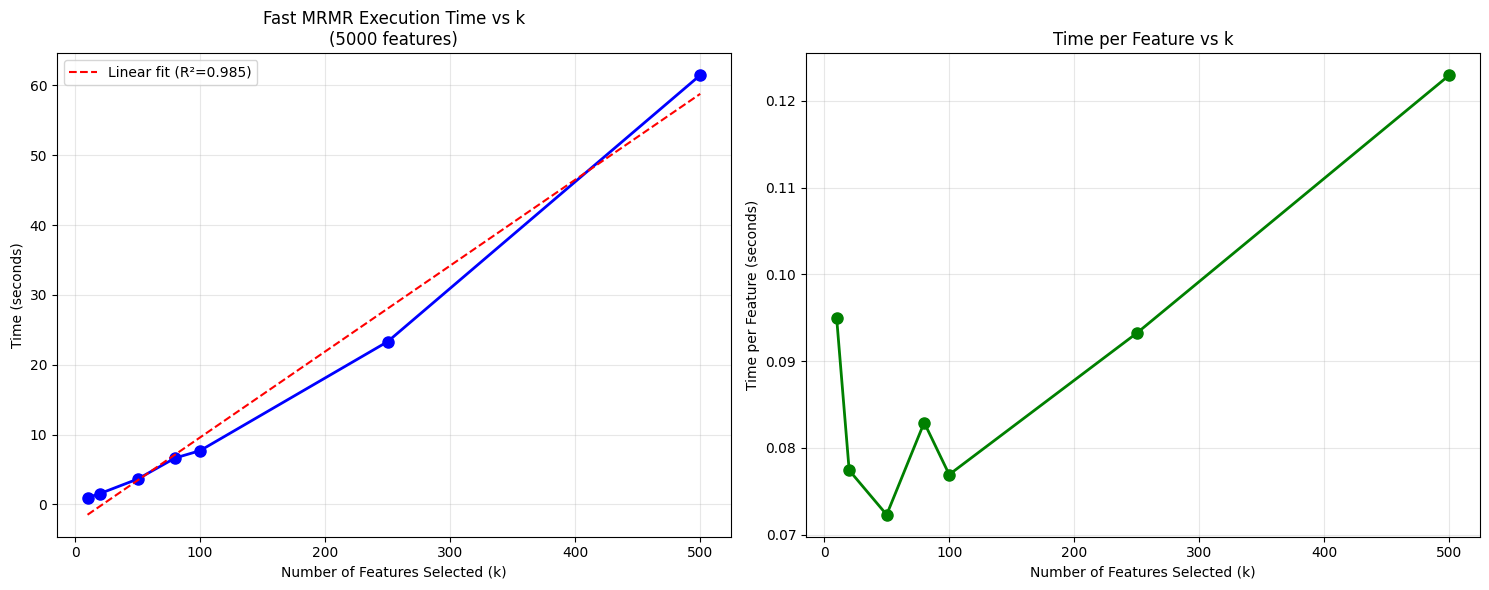

Scalability plot saved to: G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult4-FeatureSelectionBenchmark/mrmr_fast_scalability_plot_v1.png

Additional Scalability Analysis:
Fastest execution: k=10 (0.9493s)
Slowest execution: k=500 (61.4853s)
Total time for all k values: 105.2262s
Efficiency ratio (k=100 vs k=10): 64.77x


<Figure size 640x480 with 0 Axes>

In [18]:
# Plot scalability results
print("\n" + "="*60)
print("PLOTTING SCALABILITY RESULTS")
print("="*60)

plot_scalability_results(scalability_df, feature_subset_size=feature_subset_scalability)

# Additional analysis
print("\nAdditional Scalability Analysis:")
print(f"Fastest execution: k={scalability_df.loc[scalability_df['fast_time'].idxmin(), 'k']} "
      f"({scalability_df['fast_time'].min():.4f}s)")
print(f"Slowest execution: k={scalability_df.loc[scalability_df['fast_time'].idxmax(), 'k']} "
      f"({scalability_df['fast_time'].max():.4f}s)")
print(f"Total time for all k values: {scalability_df['fast_time'].sum():.4f}s")

# Calculate efficiency metrics
if len(k_values) > 1:
    efficiency_ratio = scalability_df['fast_time'].iloc[-1] / scalability_df['fast_time'].iloc[0]
    print(f"Efficiency ratio (k=100 vs k=10): {efficiency_ratio:.2f}x")